In [3]:
!pip install python-sat[pblib,aiger]

     |████████████████████████████████| 1.8 MB 26.2 MB/s 
     |████████████████████████████████| 3.4 MB 51.2 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
  Created wheel for parsimonious: filename=parsimonious-0.8.1-py3-none-any.whl size=42723 sha256=a8148a1604bea71be95500edd62fa35bea33b81abf865ee31d76e25d5c54450c
  Stored in directory: /root/.cache/pip/wheels/88/5d/ba/f27d8af07306b65ee44f9d3f9cadea1db749a421a6db8a99bf
Successfully built parsimonious


In [2]:
import pysat.solvers
from pysat.card import CardEnc as encode
from random import shuffle
import numpy as np
from math import sqrt
from tqdm import tqdm 

Rule = [[3,], [2,3]]
rulestr = lambda r: 'B' + ''.join(map(str, r[0])) + '/S' + ''.join(map(str, r[1])) + '\n'

def draw(arr):
    # cmaps =  ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
    #                     'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
    #                     'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
    cmap = 'copper'
    size = 3
    plt.figure(num = None, figsize=(size, size), dpi=300)
    plt.axis('off')
    plot = plt.imshow(arr, cmap = cmap)
    plt.show()
    plt.close()

def clauses_or(A, B, top):
    x = top + 1 
    y = top + 2

    out = [[x,y],]

    for i in A:
        out.append(i + [-x,])

    for i in B:
        out.append(i + [-y,])

    return out

def clauses_not(A, top):
    x = [top + i for i in range(1, len(A)+1)] 
    out = [[-i for i in x],]

    for k, v in enumerate(A):
        out.append(v + [-x[k],])

    return out, max(x) + 1

def m_to_rle(m):
    
    prefix = 'x = 0, y = 0, rule = ' + rulestr(Rule)
    m = [''.join(list(map(str, i)) + ['$',]) for i in m]
    S = ''.join(m)
    S = S.replace('0', 'b')
    S = S.replace('1', 'o')
    return prefix + S + '!'

for nn in range(10, 30):

    dim = (nn, nn)
    N = dim[0]*dim[1]
    Rr = ((dim[1]-1)**2)//2
    

    
        
    v = []
    t = 0
    d = dict()

    for i in range(dim[0]):
        for j in range(dim[1]):
            t += 1
            d[(i,j)] = t

            v.append((i,j))

    clauses = []
    topid = dim[0]*dim[1]+1

    for a, b in v:
        g  = d[(a,b)]

        temp = [(a+1,b),(a,b+1),  (a-1,b),(a,b-1),   (a-1,b-1),(a+1,b+1), (a-1,b+1),(a+1,b-1)]
        #temp = [ (a+1,b),(a-1,b), (a,b+1),(a,b-1), ]

        if a == dim[0]-1:
            temp = list(filter(lambda x: x not in ((a+1,b),(a+1,b+1),(a+1,b-1)), temp))

        if b == dim[1]-1:
            temp = list(filter(lambda x: x not in ((a,b+1),(a-1,b+1),(a+1,b+1)), temp))

        if a == 0:
            temp = list(filter(lambda x: x not in ((a-1,b),(a-1,b-1),(a-1,b+1)), temp))

        if b == 0:
            temp = list(filter(lambda x: x not in ((a,b-1),(a+1,b-1),(a-1,b-1)), temp))

            
        tempc = []
        c = [d[k] for k in temp]

        if len(c) > 5:
            tclaus = encode.atleast(lits = c, bound = 2, top_id = topid).clauses
            for i in tclaus:
                clauses.append([-g,] +  i)
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)


            tclaus = encode.atmost(lits = c, bound = 3, top_id = topid).clauses
            for i in tclaus:
                clauses.append([-g,] +  i)
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)



        temp1 = []
        temp2 = []

        if len(c) > 3:
            tclaus = encode.atleast(lits = c, bound = 4, top_id = topid).clauses
            for i in tclaus:
                temp1.append([ g, ] +  i)
            topid = max(max(abs(literal) for clause in clauses + temp1 for literal in clause), topid)

            tclaus = encode.atmost(lits = c, bound = 2, top_id = topid).clauses
            for i in tclaus:
                temp2.append([ g, ] +  i)
            topid = max(max(abs(literal) for clause in clauses + temp2 + temp1 for literal in clause), topid)

            for i in clauses_or(temp1, temp2, topid):
                clauses.append(i)

            

        topid += 3

        if len(c) < 8:
            clauses.append([-g, ] )
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)

            # tclaus = encode.atmost(lits = c, bound = 2, top_id = topid).clauses
            # for i in tclaus:
            #     clauses.append([ g, ] +  list(i))
            # topid = max(max(abs(literal) for clause in clauses + temp2 for literal in clause), topid)


        #clauses += tempc
    
    prArr = []

    for bbound in tqdm(range((N//2) + 1, N)):

        clausesTemp = clauses + encode.atleast(lits=[i for i in range(1,dim[0]*dim[1]+1)], top_id = topid, bound = bbound).clauses

        solver = pysat.solvers.Cadical()
        for clause in clausesTemp:
            solver.add_clause(clause)
        sat = solver.solve()


        if sat:
            
            model = solver.get_model()
            temp = [1 if i> 0 else 0 for i in model[:N]]
            
            print(Rr, nn-2, sum(temp))

            temp = np.array(temp)
            temp.resize(dim)

            print(m_to_rle(temp.tolist()))
            
            draw(temp)
        else:
            break

ModuleNotFoundError: ignored

  0%|          | 0/3 [00:00<?, ?it/s]

4 2 4
[[0 0 0 0]
 [0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]]


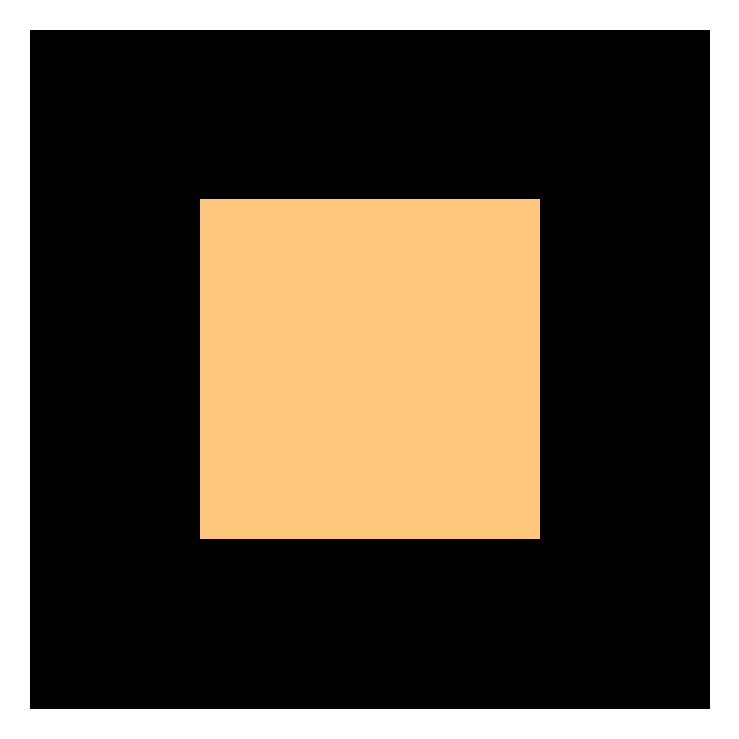

  0%|          | 0/8 [00:00<?, ?it/s]

9 3 6
[[0 0 0 0 0]
 [0 0 1 1 0]
 [0 1 0 1 0]
 [0 1 1 0 0]
 [0 0 0 0 0]]


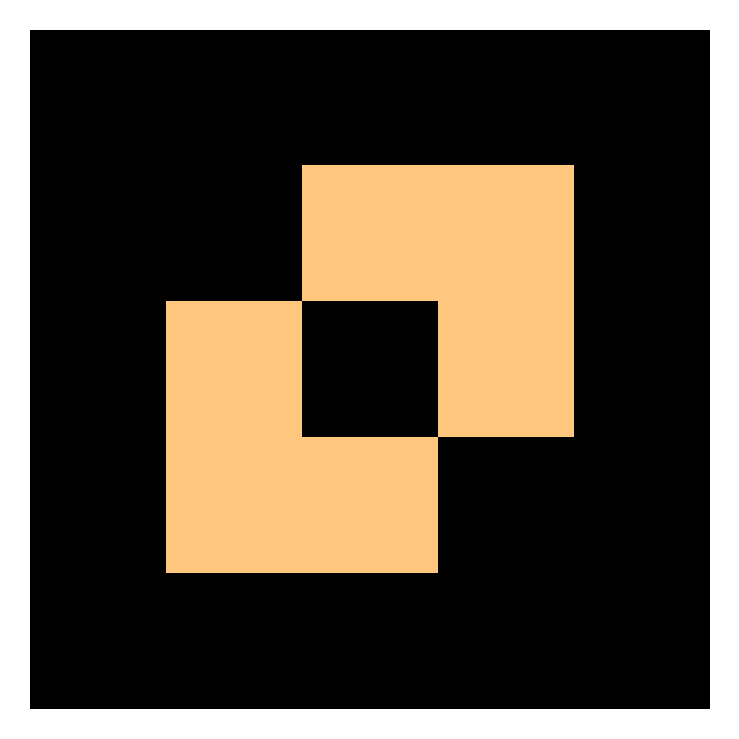

  0%|          | 0/15 [00:00<?, ?it/s]

16 4 9
[[0 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 1 1 1 0]
 [0 1 0 0 1 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]]


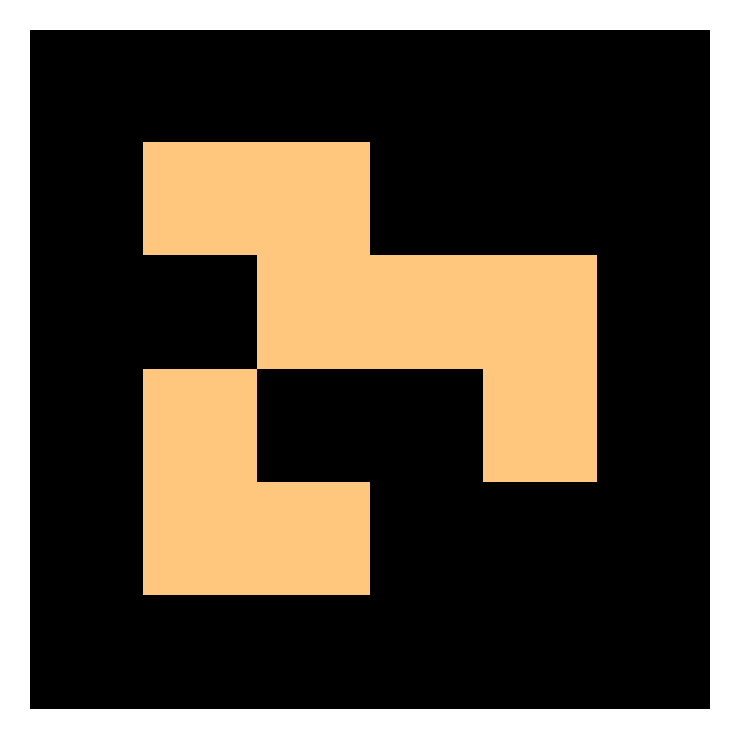

 21%|██        | 5/24 [00:00<00:00, 48.41it/s]

25 5 18
[[0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0]]


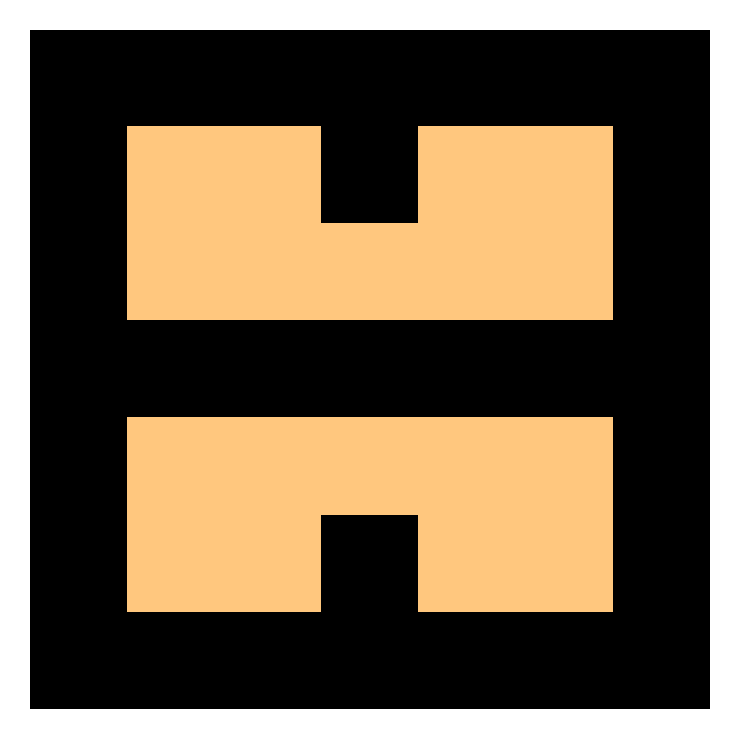

 23%|██▎       | 8/35 [00:00<00:00, 72.50it/s]

36 6 23
[[0 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0]
 [0 1 1 1 1 0 1 0]
 [0 0 0 0 0 1 1 0]
 [0 1 1 1 0 1 0 0]
 [0 1 0 1 0 1 1 0]
 [0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0]]


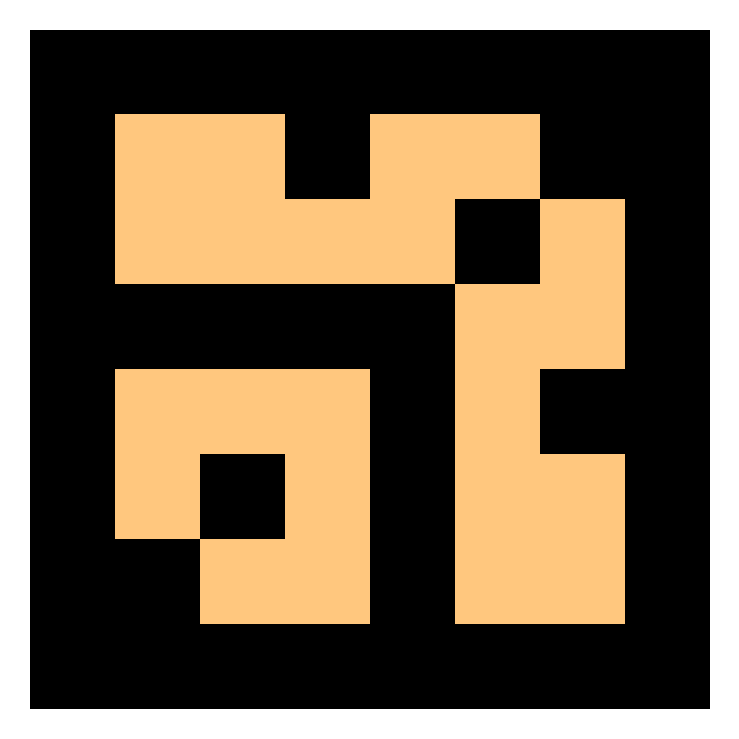

 33%|███▎      | 16/48 [00:00<00:02, 13.92it/s]

49 7 31
[[0 0 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0]
 [0 1 1 0 1 0 1 1 0]
 [0 0 1 0 1 0 1 0 0]
 [0 1 1 0 1 0 1 1 0]
 [0 0 1 0 1 0 1 0 0]
 [0 1 1 0 1 0 1 1 0]
 [0 1 1 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0]]


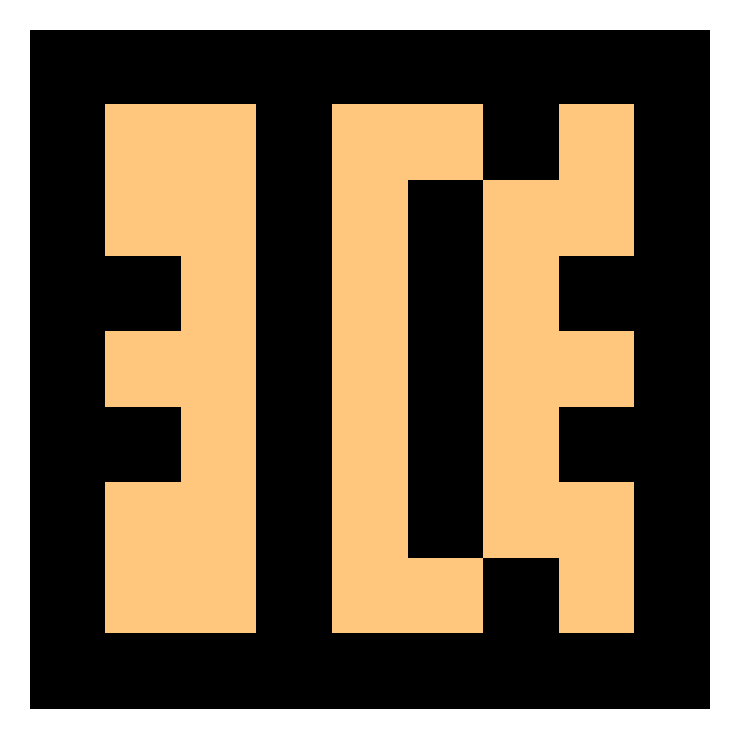

 21%|██        | 13/63 [00:00<00:02, 24.65it/s]


error: ignored

In [ ]:
import pysat.solvers
from pysat.card import CardEnc as encode
from random import shuffle
import numpy as np
from math import sqrt
from tqdm import tqdm 

Rule = [3, [2,4]] #b3s234

#Rule = [3, [1,5]] #b3s12345
#Rule = [4, [1,5]] #b4s12345

def clauses_or(A, B, top):
    x = top + 1 
    y = top + 2

    out = [[x,y],]

    for i in A:
        out.append(i + [-x,])

    for i in B:
        out.append(i + [-y,])

    return out

def clauses_not(A, top):
    x = [top + i for i in range(1, len(A)+1)] 
    out = [[-i for i in x],]

    for k, v in enumerate(A):
        out.append(v + [-x[k],])

    return out, max(x) + 1

for nn in range(4, 30):

    dim = (nn, nn)
    N = dim[0]*dim[1]
    Rr = ((dim[1]-2)**2)
    

    
        
    v = []
    t = 0
    d = dict()

    for i in range(dim[0]):
        for j in range(dim[1]):
            t += 1
            d[(i,j)] = t

            v.append((i,j))

    clauses = []
    topid = dim[0]*dim[1]+1

    for a, b in v:
        g  = d[(a,b)]

        temp = [(a+1,b),(a,b+1),  (a-1,b),(a,b-1),   (a-1,b-1),(a+1,b+1), (a-1,b+1),(a+1,b-1)]
        #temp = [ (a+1,b),(a-1,b), (a,b+1),(a,b-1), ]

        if a == dim[0]-1:
            temp = list(filter(lambda x: x not in ((a+1,b),(a+1,b+1),(a+1,b-1)), temp))

        if b == dim[1]-1:
            temp = list(filter(lambda x: x not in ((a,b+1),(a-1,b+1),(a+1,b+1)), temp))

        if a == 0:
            temp = list(filter(lambda x: x not in ((a-1,b),(a-1,b-1),(a-1,b+1)), temp))

        if b == 0:
            temp = list(filter(lambda x: x not in ((a,b-1),(a+1,b-1),(a-1,b-1)), temp))

            
        tempc = []
        c = [d[k] for k in temp]

        if len(c) > 5:
            tclaus = encode.atleast(lits = c, bound = Rule[1][0], top_id = topid).clauses
            for i in tclaus:
                clauses.append([-g,] +  i)
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)


            tclaus = encode.atmost(lits = c, bound = Rule[1][1], top_id = topid).clauses
            for i in tclaus:
                clauses.append([-g,] +  i)
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)



        temp1 = []
        temp2 = []

        if len(c) > 3:
            tclaus = encode.atleast(lits = c, bound = Rule[0]+1, top_id = topid).clauses
            for i in tclaus:
                temp1.append([ g, ] +  i)
            topid = max(max(abs(literal) for clause in clauses + temp1 for literal in clause), topid)

            tclaus = encode.atmost(lits = c, bound = Rule[0]-1, top_id = topid).clauses
            for i in tclaus:
                temp2.append([ g, ] +  i)
            topid = max(max(abs(literal) for clause in clauses + temp2 + temp1 for literal in clause), topid)

            for i in clauses_or(temp1, temp2, topid):
                clauses.append(i)

            

        topid += 3

        if len(c) < 8:
            clauses.append([ -g, ] )
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)

            # tclaus = encode.atmost(lits = c, bound = 2, top_id = topid).clauses
            # for i in tclaus:
            #     clauses.append([ g, ] +  list(i))
            # topid = max(max(abs(literal) for clause in clauses + temp2 for literal in clause), topid)


        #clauses += tempc
            

    for bbound in tqdm(range(Rr, 1, -1)):
        clausesTemp = clauses + encode.equals(lits= [i for i in range(1,dim[0]*dim[1] +1)], top_id = topid, bound = bbound).clauses

        solver = pysat.solvers.Cadical()

        for clause in clausesTemp:
            solver.add_clause(clause)

        sat = solver.solve()

        if sat:
            
            model = solver.get_model()
            temp = [1 if i> 0 else 0 for i in model[:N]]
            
            print(Rr, nn-2, sum(temp))

            temp = np.array(temp)
            temp.resize(dim)

            print(temp)
            
            import matplotlib.pyplot as plt

            # cmap =  ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
            #                     'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
            #                     'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
            cmap = 'copper'
            # cmap = 'copper'
            size = 3
            plt.figure(num = None, figsize=(size, size), dpi=300)
            plt.axis('off')
            plot = plt.imshow(temp, cmap = cmap)
            plt.show()
            plt.close()
            break

        else:
            pass

  0%|          | 0/7 [00:00<?, ?it/s]

8 3 5
[[0 0 0 0 0]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]


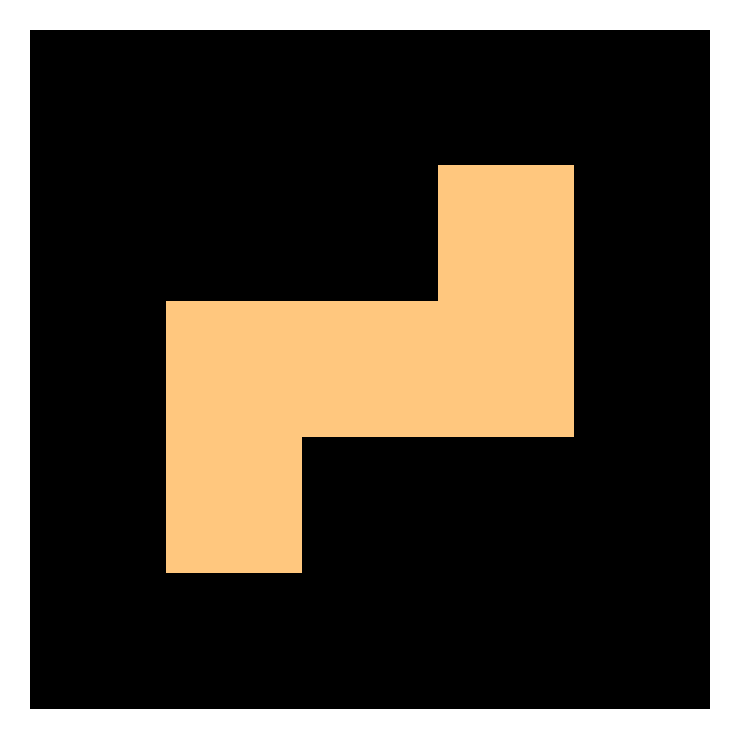

  0%|          | 0/11 [00:00<?, ?it/s]

12 4 8
[[0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 1 0]
 [0 0 1 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]]


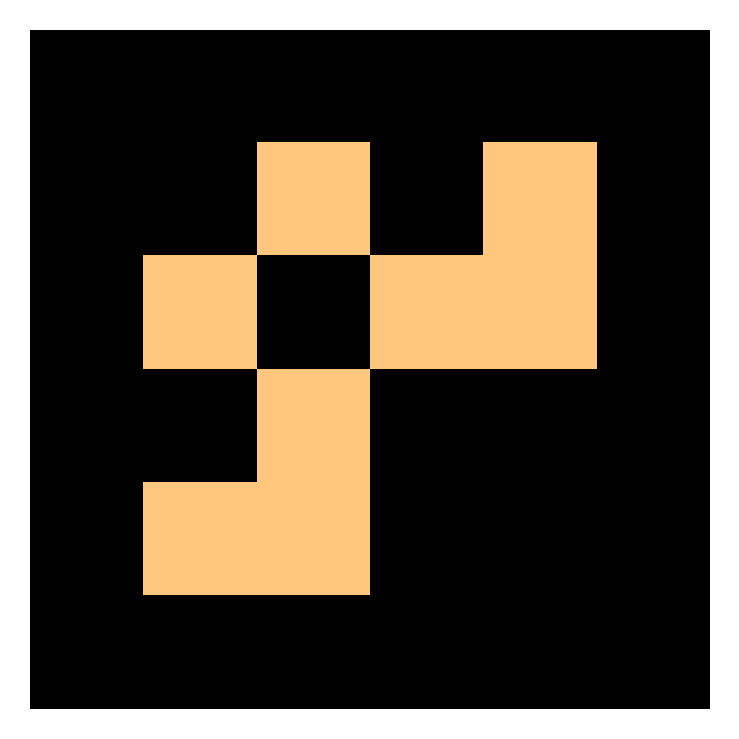

  0%|          | 0/17 [00:00<?, ?it/s]

18 5 15
[[0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0]
 [0 0 1 0 1 0 0]
 [0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0]]


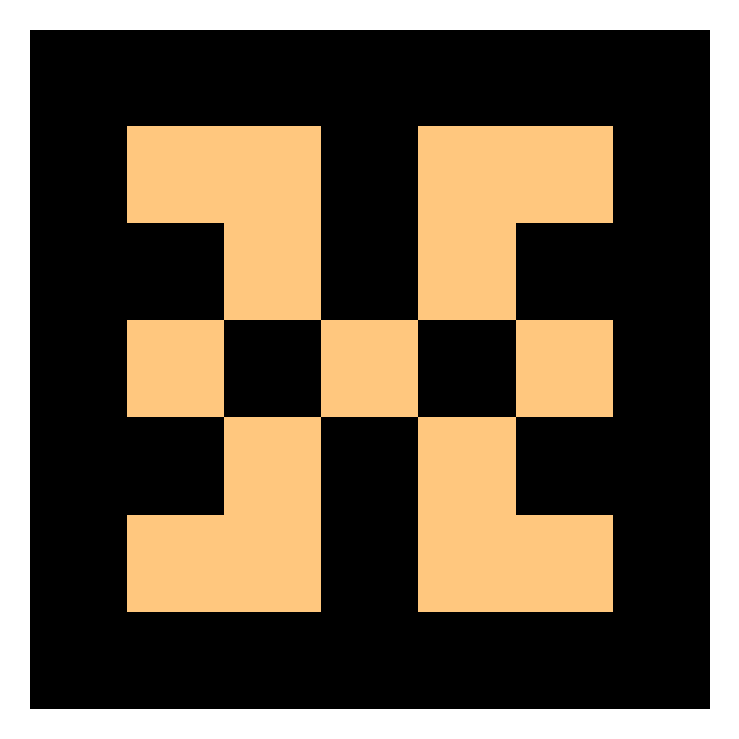

 17%|█▋        | 4/23 [00:01<00:06,  2.93it/s]

24 6 20
[[0 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 1 0 1 1 0 0]
 [0 1 1 0 1 1 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0]]


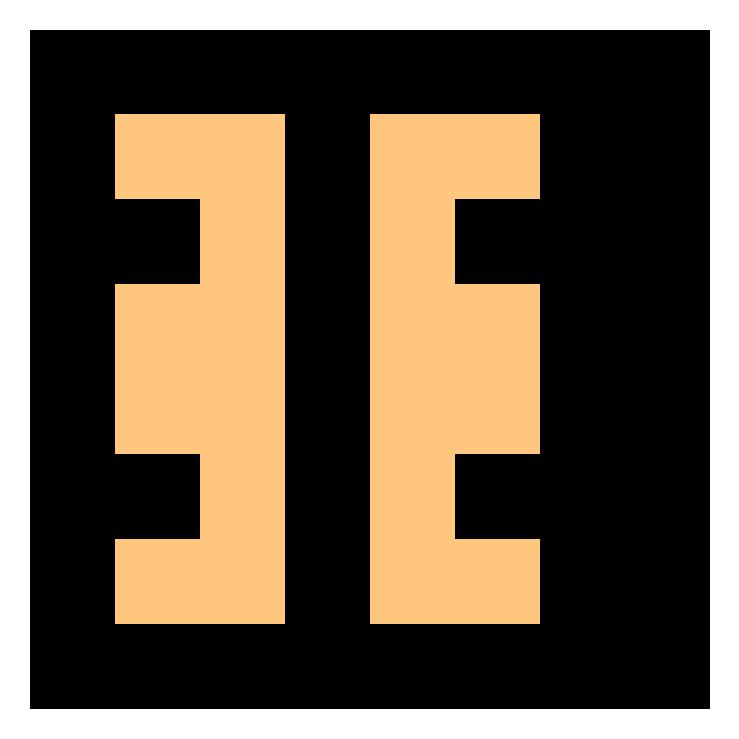

 13%|█▎        | 4/31 [00:02<00:21,  1.27it/s]

32 7 28
[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 1 0]
 [0 1 1 1 1 0 1 0 0]
 [0 0 0 1 0 1 1 0 0]
 [0 1 1 0 0 0 1 1 0]
 [0 0 1 1 0 1 0 0 0]
 [0 0 1 0 1 1 1 1 0]
 [0 1 1 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]]


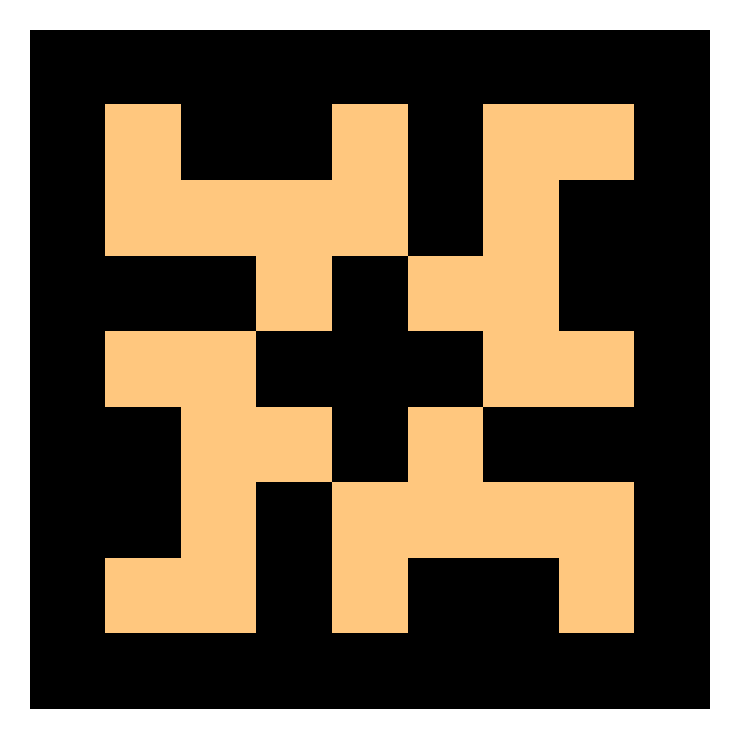

 13%|█▎        | 4/31 [00:04<00:29,  1.10s/it]


KeyboardInterrupt: ignored

In [ ]:
import pysat.solvers
from pysat.card import CardEnc as encode
from random import shuffle
import numpy as np
from math import sqrt
from tqdm import tqdm 


Rule = [[3,], [2,4]]


def clauses_or(A, B, top):
    x = top + 1 
    y = top + 2

    out = [[x,y],]

    for i in A:
        out.append(i + [-x,])

    for i in B:
        out.append(i + [-y,])

    return out

def clauses_or_list(S, top):
    x = [top + i for i in range(1, len(S)+1)] 
    out = [x.copy(), ]
    for k, A in enumerate(S):
            for i in A:
                out.append(i + [-x[k],])
    return out

def clauses_not(A, top):
    x = [top + i for i in range(0, len(A)+2)] 
    out = [[-i for i in x],]

    for k, v in enumerate(A):
        out.append(v + [-x[k],])

    return out

for nn in range(4, 30):

    dim = (nn, nn)
    N = dim[0]*dim[1]
    Rr = ((dim[1]-1)**2)//2

    v = []
    t = 0
    d = dict()

    for i in range(dim[0]):
        for j in range(dim[1]):
            t += 1
            d[(i,j)] = t

            v.append((i,j))

    clauses = []
    topid = dim[0]*dim[1]+1

    for a, b in v:
        g  = d[(a,b)]

        temp = [(a+1,b),(a,b+1),  (a-1,b),(a,b-1),   (a-1,b-1),(a+1,b+1), (a-1,b+1),(a+1,b-1)]
        #temp = [ (a+1,b),(a-1,b), (a,b+1),(a,b-1), ]

        if a == dim[0]-1:
            temp = list(filter(lambda x: x not in ((a+1,b),(a+1,b+1),(a+1,b-1)), temp))

        if b == dim[1]-1:
            temp = list(filter(lambda x: x not in ((a,b+1),(a-1,b+1),(a+1,b+1)), temp))

        if a == 0:
            temp = list(filter(lambda x: x not in ((a-1,b),(a-1,b-1),(a-1,b+1)), temp))

        if b == 0:
            temp = list(filter(lambda x: x not in ((a,b-1),(a+1,b-1),(a-1,b-1)), temp))

            
        tempc = []
        c = [d[k] for k in temp]

        if len(c) > 5 :
            S = []
            for Item_rule in Rule[1] :
                if len(c) >= Item_rule:
                    temp2 = encode.equals(lits = c, bound = Item_rule, top_id = topid).clauses
                    topid = max(max(abs(literal) for clause in clauses + temp2 for literal in clause), topid)
                    S.append(temp2.copy())
            
            for i in clauses_or_list(S, topid):
                clauses.append([-g,] +i)
            topid = max(max(abs(literal) for clause in clauses + temp2 for literal in clause), topid)



        if len(c) > 3:

            for Item_rule in Rule[0]:
                if len(c) >= Item_rule:

                    temp1 = []
                    temp2 = []

                    if Item_rule < 8:
                        tclaus = encode.atleast(lits = c, bound = Item_rule+1, top_id = topid).clauses
                        for i in tclaus:
                            temp1.append([ g, ] +  i)
                        topid = max(max(abs(literal) for clause in clauses + temp1 for literal in clause), topid)

                        tclaus = encode.atmost(lits = c, bound = Item_rule-1, top_id = topid).clauses
                        for i in tclaus:
                            temp2.append([ g, ] +  i)
                        topid = max(max(abs(literal) for clause in clauses + temp2 + temp1 for literal in clause), topid)

                        for i in clauses_or(temp1, temp2, topid):
                            clauses.append(i)
                    else:
                        tclaus = encode.atmost(lits = c, bound = Item_rule-1, top_id = topid).clauses
                        for i in tclaus:
                            clauses.append([ g, ] +  i)
                        topid = max(max(abs(literal) for clause in clauses + temp2 + temp1 for literal in clause), topid)


            

        topid += 3

        if len(c) < 8:

            clauses.append([ -g, ])
            # print(clauses)
            topid = max(max(abs(literal) for clause in clauses for literal in clause), topid)

            # tclaus = encode.atmost(lits = c, bound = 2, top_id = topid).clauses
            # for i in tclaus:
            #     clauses.append([ g, ] +  list(i))
            # topid = max(max(abs(literal) for clause in clauses + temp2 for literal in clause), topid)


        #clauses += tempc
            

    for bbound in tqdm(range(Rr, 1, -1)):
        clausesTemp = clauses + encode.equals(lits= [i for i in range(1,dim[0]*dim[1] +1)], top_id = topid, bound = bbound).clauses

        solver = pysat.solvers.Cadical()

        for clause in clausesTemp:
            solver.add_clause(clause)

        sat = solver.solve()

        if sat:
            
            model = solver.get_model()
            temp = [1 if i> 0 else 0 for i in model[:N]]
            
            print(Rr, nn-2, sum(temp))

            temp = np.array(temp)
            temp.resize(dim)

            print(temp)
            
            import matplotlib.pyplot as plt

            # cmap =  ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
            #                     'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
            #                     'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
            cmap = 'copper'
            # cmap = 'copper'
            size = 3
            plt.figure(num = None, figsize=(size, size), dpi=300)
            plt.axis('off')
            plot = plt.imshow(temp, cmap = cmap)
            plt.show()
            plt.close()
            break

        else:
            pass